# Finding the Best Neighbourhood

## Introduction

## The Metric

## Importing Data

In [1]:
# Set Up
#Imports pandas, geopandas, and matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

#Imports the neighborhoods GDF
neighborhood_url = "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson"
neighborhood_gdf = geopandas.read_file("Neighborhoods_.shp").set_index('hood')

## Arrest

In [2]:
# Arrest Data
#Reads Dom's arrest csv
arrest = pd.read_csv("arrests.csv")
#Adds column for Dom's arrests labeled 'arrests'
filterarrest = arrest.groupby("INCIDENTNEIGHBORHOOD")["OFFENSES"].count()
try:
    neighborhood_gdf.insert(0,"arrests",filterarrest)
except ValueError:
    neighborhood_gdf['arrests'] = filterarrest

### Fire Incidents

The data for this section came from the WPRDC website's fire alarm data.

In order to properly organise the data I got, I imported th data from the csv file into a python **dictionary**. This way, I can easily print out the content of the data I need in ways I want to present it.

In order to align the dates of the data, I filter the incoming data so only fire alarm data from the year 2016-2020 will be taken into acccount.

After the importing is done, I will make a dataframe out of the dictionary, and conatenate the dataframe to the overall dataframe.|

In [3]:
# Fire Incident data
#Reads Alex's fire incidents csv
fire_data = pd.read_csv("Fire_Alarm.csv")
#Adds column for Alex's fire incidents labeled 'fires'
neighbourhood_dictionary = {}
name = ""
counter = 0
neighbourhood_counter = 0
# put all data into a dictionary
for index, row in fire_data.iterrows():
    neighborhood = row["neighborhood"]
    time = row["alarm_time"]
    if(type(time) == str):
        if(time.startswith("2016") or time.startswith("2017") or time.startswith("2018") or time.startswith("2019") or time.startswith("2020")):
            if(neighborhood not in neighbourhood_dictionary.keys()):
                neighbourhood_dictionary.update({neighborhood: [neighborhood, 1]})
                continue
            counter = neighbourhood_dictionary[neighborhood]
            counter[1] += 1
            neighbourhood_dictionary.update({neighborhood: counter})
# Import the data from the dictionary into a dataframe
neighborhood_df = pd.DataFrame.from_dict(neighbourhood_dictionary, orient = "index")
neighborhood_df.columns = ["Neighbourhood", "Number of Incidents"]
neighborhood_df = neighborhood_df.dropna()
neighborhood_df = neighborhood_df.drop(index=['Mount Oliver Borough'])
# Add the dataframe's value to the concatenate dataframe
try:
    neighborhood_gdf.insert(1,"fires", neighborhood_df['Number of Incidents'])
except ValueError:
    neighborhood_gdf['fires'], neighborhood_df['Number of Incidents']

### Car Crashes

In [4]:
# Crash Data
#Grabs Sean's data from the WPRDC (Will probably be redone to just store the stuff in the files)
crashes_2020_url = "https://data.wprdc.org/datastore/dump/514ae074-f42e-4bfb-8869-8d8c461dd824"
crashes_2019_url = "https://data.wprdc.org/datastore/dump/cb0a4d8b-2893-4d20-ad1c-47d5fdb7e8d5"
crashes_2018_url = "https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/48f30bee-e404-4cf5-825b-b0da3c975e45/download/crash-data-2018.csv"
crashes_2017_url = "https://data.wprdc.org/datastore/dump/bf8b3c7e-8d60-40df-9134-21606a451c1a"
crashes_2016_url = "https://data.wprdc.org/datastore/dump/9ccea350-e062-45e2-ade5-45e9378f40d2"
crashes_df=pd.concat([pd.read_csv(crashes_2020_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2019_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2018_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2017_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2016_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']]
                         ],ignore_index=True)
crashes_gdf = geopandas.GeoDataFrame(crashes_df, geometry=geopandas.points_from_xy(crashes_df.DEC_LONG, crashes_df.DEC_LAT, crs=4326))
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212
#Adds column for Sean's crashes labeled 'crashes'
pittsburgh_crashes = geopandas.GeoDataFrame(columns=crashes_gdf.columns.append(pd.Index(['hood'])), geometry='geometry', crs=4326)
crash_count = []
for i in neighborhood_gdf.index:
    bool_crashes = crashes_gdf.within(neighborhood_gdf.loc[i].geometry)
    try:
        count = bool_crashes.value_counts().loc[True]
    except KeyError:
        count = 0
    crash_count.append(count)
    neighborhood_crashes = crashes_gdf[bool_crashes].assign(hood=i)
    pittsburgh_crashes = pd.concat([neighborhood_crashes, pittsburgh_crashes])
try:
    neighborhood_gdf.insert(1, "crashes", pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index)))
except ValueError:
    neighborhood_gdf['crashes'] = pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index))

In [5]:
# Final Dataframe with all the data combined
# Lincoln-Lemington-Belmar's square mile data was broken, it was reading 0.28 sqmiles from the file but it is way larger
# sqmile data came from google
# Add in the Arrest/Fire/Crash per square mile data
neighborhood_gdf.loc["Lincoln-Lemington-Belmar", "sqmiles"] = 1.812
neighborhood_gdf = neighborhood_gdf.assign(arrests_sqmile = lambda x: x['arrests'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(fires_sqmile = lambda x: x['fires'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_sqmile = lambda x: x['crashes'] / x['sqmiles'])
neighborhood_gdf

,arrests,crashes,fires,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,...,created_us,created_da,last_edite,last_edi_1,Shape__Are,Shape__Len,geometry,arrests_sqmile,fires_sqmile,crashes_sqmile
hood,,,,,,,,,,,,,,,,,,,,,
Central Oakland,439.0,233,37,1,0.0,42,003,040500,1,420030405001,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,7.842997e+06,11525.904546,"POLYGON ((-79.95304 40.44203, -79.95302 40.442...",1562.277580,131.672598,829.181495
North Oakland,358.0,298,47,2,1.0,42,003,040400,1,420030404001,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,1.390469e+07,20945.562570,"POLYGON ((-79.95455 40.45882, -79.95427 40.458...",717.434870,94.188377,597.194389
West Oakland,255.0,122,24,3,2.0,42,003,040200,2,420030402002,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,5.998649e+06,18280.484515,"POLYGON ((-79.96230 40.44294, -79.96220 40.442...",1186.046512,111.627907,567.441860
Crawford-Roberts,685.0,116,36,4,3.0,42,003,030500,2,420030305002,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,7.203337e+06,15697.914337,"POLYGON ((-79.98275 40.44641, -79.98273 40.446...",2655.038760,139.534884,449.612403
Strip District,416.0,474,27,5,5.0,42,003,020300,1,420030203001,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,1.694875e+07,24019.532672,"POLYGON ((-79.97494 40.45629, -79.97484 40.456...",684.210526,44.407895,779.605263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ridgemont,29.0,150,7,88,298.0,42,003,563100,3,420035631003,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,1.024662e+07,16308.779881,"POLYGON ((-80.03431 40.43366, -80.03424 40.433...",78.590786,18.970190,406.504065
West End,233.0,312,13,89,32.0,42,003,562600,1,420035626001,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,5.579476e+06,18778.991513,"POLYGON ((-80.02869 40.44454, -80.02845 40.444...",1165.000000,65.000000,1560.000000
California-Kirkbride,239.0,36,17,90,57.0,42,003,250700,1,420032507001,...,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,6.050817e+06,11709.518764,"POLYGON ((-80.02039 40.46285, -80.02022 40.462...",1101.382488,78.341014,165.898618


## Plotting the Data

### Arrests

(-80.10681367594599, -79.8543203064025, 40.35464264383522, 40.50793369806537)

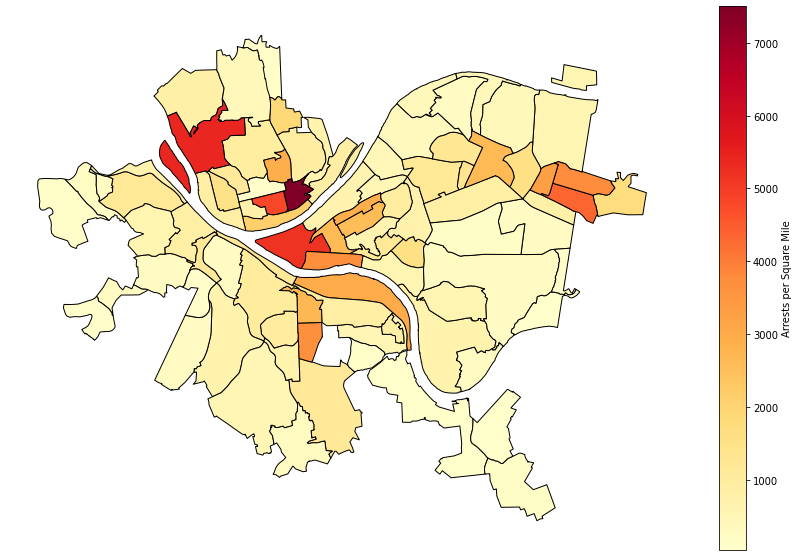

In [6]:
#Arrests Plot

neighborhood_gdf.plot(figsize=(15,10), column = "arrests_sqmile",
                    cmap = "YlOrRd",
                   legend = True,
                   legend_kwds = {"label":"Arrests per Square Mile"},
                   edgecolors = "black")
plt.axis("off")

### Fire Incidents

For this section, we will look at the number of fire incidents per square mile of each neighbourhood.

But before we plot the data out, lets take a look at the top 10 most livable neighbourhood in Pittsburgh. 

To organise the data, again, I used python **dictionary** to help me visualise the data.

In [7]:
# Top 10 Best Neighbourhood For Fire Incidents Per Square Mile
fire_sqmiles_dict = {}
hood_name = neighborhood_gdf.index.tolist()
fire_sqmiles_value = neighborhood_gdf["fires_sqmile"].tolist()
i = 0
for x in hood_name:
    fire_sqmiles_dict.update({x: int(fire_sqmiles_value[i])})
    i += 1
temp = sorted(fire_sqmiles_dict, key=fire_sqmiles_dict.get, reverse=True)
i = 0
for x in temp:
    if i > 9: break
    print(i+1, ":", x,", Fire Incident Per Square Mile:", fire_sqmiles_dict[x])
    i+=1
# YES THIS IS WAY MORE COMPLICATED THAN IT NEEDS TO BE BUT IT WORKS

1 : Knoxville , Fire Incident Per Square Mile: 278
2 : East Allegheny , Fire Incident Per Square Mile: 262
3 : Marshall-Shadeland , Fire Incident Per Square Mile: 251
4 : Central Northside , Fire Incident Per Square Mile: 231
5 : Bluff , Fire Incident Per Square Mile: 211
6 : Homewood North , Fire Incident Per Square Mile: 198
7 : Central Business District , Fire Incident Per Square Mile: 196
8 : Allentown , Fire Incident Per Square Mile: 186
9 : Homewood South , Fire Incident Per Square Mile: 175
10 : Middle Hill , Fire Incident Per Square Mile: 160


Then we will plot the data out with **geopandas** to see if the results match.

(-80.10681367594599, -79.8543203064025, 40.35464264383522, 40.50793369806537)

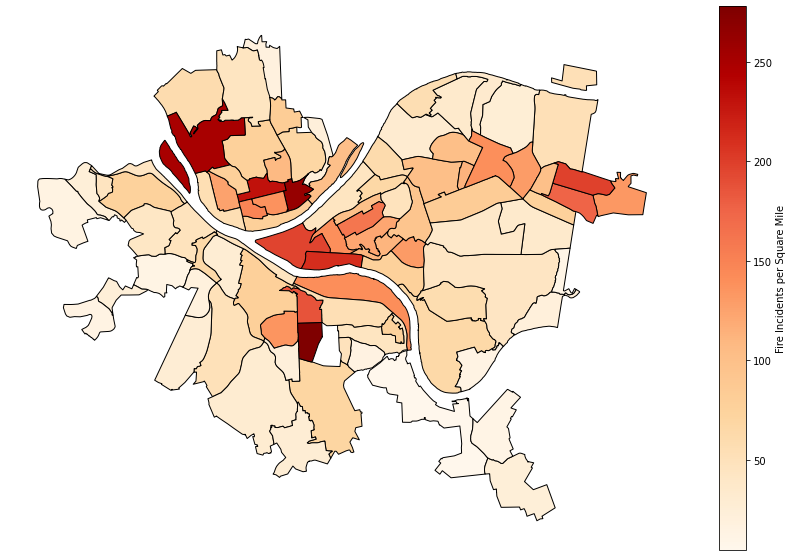

In [8]:
#Fire Incidents Plot
neighborhood_gdf.plot(column='fires_sqmile',
              cmap='OrRd',            
              edgecolor="black",      
              legend=True,              
              legend_kwds={'label': "Fire Incidents per Square Mile"}, 
              figsize=(15, 10),         
              )
plt.axis("off")

So, as the data shown, the most livable neighbourhood in Pittsburgh, according to the number of fire incidents alone, will be **Knoxville**, coming in at second place is **East Allegheny**, and coming in at third place is **Marshall-Shadeland**.

But nonetheless, this only accounts for 1/3 of the total data used for the final calculation, and all the neighbourhood will be taken into account for the final calculation, no matter the ranking they got here.

### Car Crashes

(-80.10681367594599, -79.8543203064025, 40.35464264383522, 40.50793369806537)

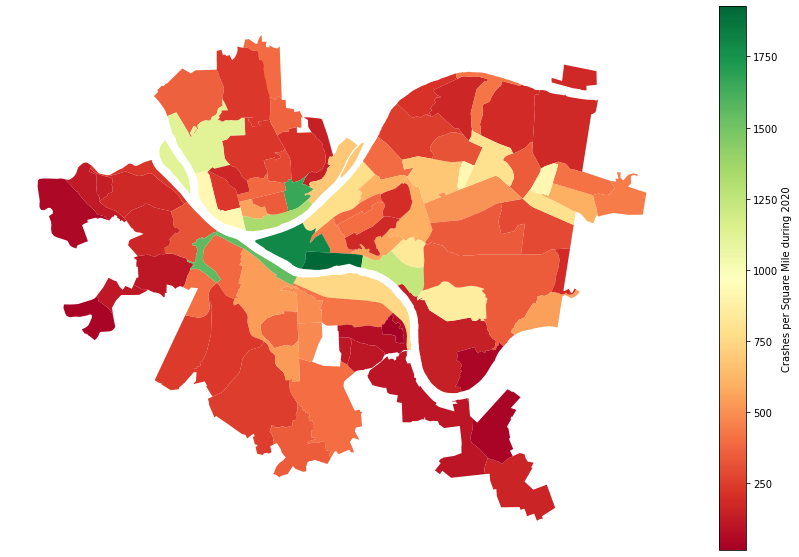

In [9]:
#Crashes Plot
neighborhood_gdf.plot(column='crashes_sqmile',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Crashes per Square Mile during 2020'},
                      figsize=(15,10))
plt.axis('off')

### Final Results

In [10]:
max_series = neighborhood_gdf[['arrests_sqmile','fires_sqmile','crashes_sqmile']].max()
neighborhood_gdf = neighborhood_gdf.assign(arrests_1 = lambda x: x['arrests_sqmile'] / max_series['arrests_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(fires_1 = lambda x: x['fires_sqmile'] / max_series['fires_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_1 = lambda x: x['crashes_sqmile'] / max_series['crashes_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(score = lambda x: (x['arrests_1'] + x['fires_1'] + x['crashes_1']) / 3 * 100)

(-80.10681367594599, -79.8543203064025, 40.35464264383522, 40.50793369806537)

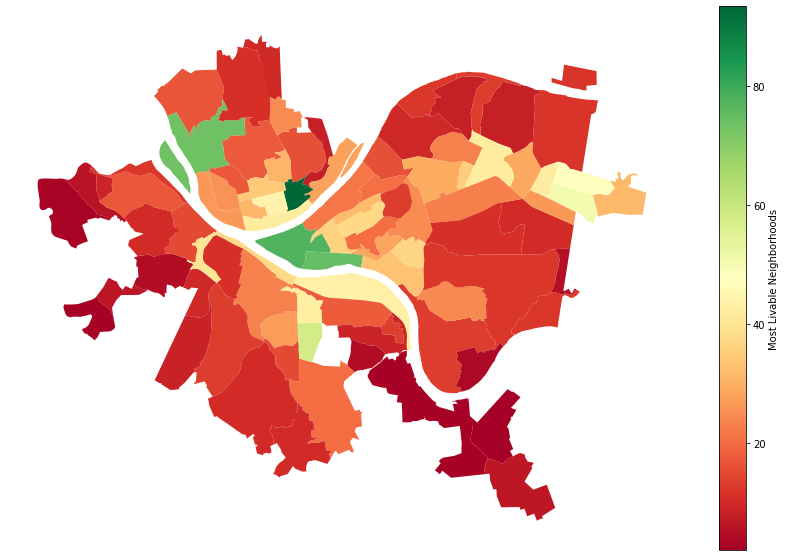

In [11]:
neighborhood_gdf.plot(column='score',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Most Livable Neighborhoods'},
                      figsize=(15,10))
plt.axis('off')

In [12]:
sort_items = list(neighborhood_gdf.sort_values('score', ascending=False)['score'].items())
for i in range(len(sort_items)):
    pair = sort_items[i]
    print(str(i+1) + ". " + pair[0] + " - " + str(int(pair[1])))

1. East Allegheny - 93
2. Central Business District - 77
3. Bluff - 75
4. Marshall-Shadeland - 73
5. Knoxville - 58
6. Homewood South - 50
7. Homewood North - 47
8. Allegheny Center - 44
9. South Side Flats - 43
10. Allentown - 42
11. Homewood West - 42
12. North Shore - 42
13. East Liberty - 42
14. West End - 39
15. South Shore - 37
16. Middle Hill - 37
17. Central Oakland - 37
18. Crawford-Roberts - 36
19. Friendship - 35
20. Central Northside - 34
21. South Oakland - 33
22. Bedford Dwellings - 31
23. East Hills - 31
24. Allegheny West - 30
25. Fineview - 30
26. Bloomfield - 29
27. Larimer - 28
28. West Oakland - 28
29. Troy Hill - 28
30. Beltzhoover - 27
31. Chateau - 26
32. Point Breeze North - 26
33. Manchester - 25
34. North Oakland - 24
35. Northview Heights - 24
36. Greenfield - 24
37. Mount Washington - 23
38. Garfield - 23
39. Shadyside - 22
40. Strip District - 21
41. Polish Hill - 20
42. Terrace Village - 20
43. Carrick - 20
44. South Side Slopes - 18
45. Perry South - 17
4

ValueError: cannot convert float NaN to integer

In [ ]:
for index, row in neighborhood_gdf[['arrests','fires','crashes']].iterrows():
    print(index + ": arrests-" + str(row['arrests']) + ", fires-" + str(row['fires']) + ", crashes-" + str(row['crashes']))

## Final Conclusion

### Alex's Conclusion

So from the final results, we know that **East Allegheny** won out as the most livable neighbourhood. And from the fire incident data, we know that **East Allegheny** came in second for that section. My head horse, **Knoxville**, ended up coming in fifth. I am not very suprised with the result since **Knoxville** did not have a giant lead over **East Allegheny**. But overall I'd say fire incident data is a great reflection of the final result as the top 10 most livable neighbourhood according to fire incidents alone a place relatively high on the final list.